任务2.1
使用简单CNN作为分类器，完成Cifar10分类任务

# Setup

In [1]:
import os
import torch
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

MODELS_DIR = './models/'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)

In [34]:
def get_args():
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--DATASETS-DIR', type=str, default='D:/datasets',
                        help='directory of datasets')
    parser.add_argument('--valid-split', type=float, default=0.2,
                        help='ratio of validation set')
    parser.add_argument('--epochs', type=int, default=30, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--optimizer-name', default='Adam',
                        help='name of the optimizer')
    parser.add_argument('--init-lr', type=float, default=0.01, metavar='LR',
                        help='initial learning rate')
    parser.add_argument('--criterion', default=nn.CrossEntropyLoss(),
                        help='loss function of training')
    parser.add_argument('--EarlyStop', default=True,
                        help='enable using early stop')
    parser.add_argument('--lrscheduler', default=True,
                        help='enable using learning rate scheduler')
    parser.add_argument('--MODEL-PATH', type=str,
                        help='directory to save model')
    args = parser.parse_args(args=[])
    return args


def create_dataloader(args):
    '''
    load Cifar 10 dataset
    :param batch_size:
    :param valid_size:
    :param DIR: directory of the dataset
    :return: train_loader, valid_loader, test_loader
    '''
    # convert data to torch.FloatTensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # choose the training and test datasets
    train_data = datasets.CIFAR10(root=args.DATASETS_DIR,
                                train=True,
                                download=True,
                                transform=transform)

    test_data = datasets.CIFAR10(root=args.DATASETS_DIR,
                               train=False,
                               download=False,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(args.valid_split * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=args.batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=args.batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=args.test_batch_size,
                                              num_workers=0)

    return train_loader, valid_loader, test_loader


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        acc = pred.eq(target.view_as(pred)).sum().item() / args.batch_size
        train_accuracy += acc
        loss = args.criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), acc,
            ))
            if args.dry_run:
                break
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    return train_loss, train_accuracy


def validate(args, model, device, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += args.criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            val_acc += pred.eq(target.view_as(pred)).sum().item() / args.batch_size
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    return val_loss, val_acc


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += args.criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracy = correct / len(test_loader.dataset)

    return test_loss, test_accuracy


class EarlyStop():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, args, val_loss, model):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif (self.best_loss - val_loss) > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif (self.best_loss - val_loss) < self.min_delta:
            print(f'INFO: Early stopping counter {self.counter+1} of {self.patience}')
            if self.counter == 0:
                print('Saving Model to ' + args.model_path)
                torch.save(model.state_dict(), args.model_path)
            self.counter += 1
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


def main(args, model):
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using', device)

    train_loader, val_loader, test_loader = create_dataloader(args)

    model = model.to(device)

    optimizer_name = args.optimizer_name
    init_lr = args.init_lr
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=init_lr)

    if args.EarlyStop:
        earlystop = EarlyStop()

    if args.lrscheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=args.T_max
            )

    train_history = {'train_loss': [], 'train_acc': []}
    val_history = {'val_loss': [], 'val_acc': []}

    for epoch in range(1, args.epochs + 1):
        train_loss, train_acc = train(args, model, device, train_loader, optimizer, epoch)
        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)

        val_loss, val_acc = validate(args, model, device, val_loader)
        val_history['val_loss'].append(val_loss)
        val_history['val_acc'].append(val_acc)

        print('\nTrain Epoch: {}\tTrain Loss: {:.6f}\tTrain Accuracy: {:.6f}'
              '\n\t\t\tValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}\n'.format(
              epoch, train_loss, train_acc, val_loss, val_acc
        ))

        if args.EarlyStop:
            earlystop(args, val_loss, model)
            if earlystop.early_stop:
              break
        if args.lrscheduler:
            scheduler.step()

    if args.EarlyStop:
      model.load_state_dict(torch.load(args.model_path))

    test_loss, test_acc = test(args, model, device, test_loader)
    test_history = {'test_loss': test_loss, 'test_acc': test_acc}
    history = {
        'train_history': train_history,
        'val_history': val_history,
        'test_history': test_history,
    }
    return history, model


def plot_res(history, title, PATH):
    train_history = history['train_history']
    val_history = history['val_history']
    test_history = history['test_history']

    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.suptitle(title, fontsize=25)

    epochs = [i+1 for i in range(len(train_history['train_loss']))]

    plt.subplot(121)
    plt.title('Loss', fontsize=20)
    plt.plot(epochs, train_history['train_loss'], color='blue')
    plt.plot(epochs, val_history['val_loss'], color='red')
    plt.legend(['Train Loss', 'Validation Loss'], loc='upper right', fontsize=15)
    plt.xticks(epochs[::2])
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('CrossEntropy Loss', fontsize=15)

    plt.subplot(122)
    plt.title('Accuracy', fontsize=20)
    plt.plot(epochs, train_history['train_acc'], color='blue')
    plt.plot(epochs, val_history['val_acc'], color='red')
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best', fontsize=15)
    plt.xlabel('epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xticks(epochs[::2])
    plt.subplots_adjust(bottom=0.4)
    plt.figtext(0.5, -0.05, 'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}'.format(**test_history), ha="center",
                fontsize=20, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})

    plt.savefig(PATH, bbox_inches='tight')
    plt.show()

# Visualize Data

In [15]:
args = get_args()
_, _, test_loader = create_dataloader(args)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

Files already downloaded and verified


torch.Size([1000, 3, 32, 32])

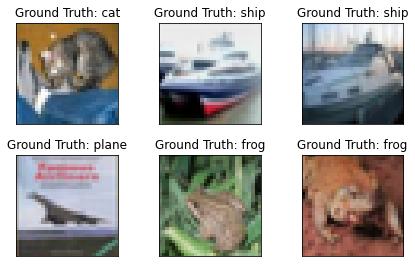

In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  imshow(example_data[i])
  plt.title("Ground Truth: {}".format(
      classes[example_targets[i]]
  ))
  plt.xticks([])
  plt.yticks([])

plt.show()

# Build Model

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64*2*2, 32)
        self.fc2 = nn.Linear(32, 10)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        x = x.view(-1, 64*2*2)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))

        return x

torch.Size([1000, 10])

# Train the Model

In [35]:
model = Net()
MODEL_PATH = os.path.join(MODELS_DIR, 'ResNet_fp.pt')
args = get_args()
args.model_path = MODEL_PATH
args.EarlyStop = False
args.lrscheduler = False
history, model = main(args, model)

Using cpu
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302077	Accuracy: 0.109375
Train Epoch: 1 [3200/50000 (8%)]	Loss: 2.234354	Accuracy: 0.234375
Train Epoch: 1 [6400/50000 (16%)]	Loss: 2.214615	Accuracy: 0.234375
Train Epoch: 1 [9600/50000 (24%)]	Loss: 2.246303	Accuracy: 0.203125
Train Epoch: 1 [12800/50000 (32%)]	Loss: 2.299657	Accuracy: 0.156250
Train Epoch: 1 [16000/50000 (40%)]	Loss: 2.225773	Accuracy: 0.234375
Train Epoch: 1 [19200/50000 (48%)]	Loss: 2.332265	Accuracy: 0.125000
Train Epoch: 1 [22400/50000 (56%)]	Loss: 2.350470	Accuracy: 0.109375
Train Epoch: 1 [25600/50000 (64%)]	Loss: 2.320480	Accuracy: 0.140625


KeyboardInterrupt: 